In [72]:
import wandb
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
api = wandb.Api()
wandb_entity="ceb-sre"
wandb_project="orderly"

In [61]:
DATASETS = ["with_trust_with_map","with_trust_no_map", "no_trust_no_map", "no_trust_with_map", ]
lines = ["Solvents", "Agents", "Everything"]
for dataset in DATASETS:
    filters = {
        "state": "finished",
        "config.output_folder_path": f"models/{dataset}",
        "config.random_seed": 12345,
        "config.train_fraction": 1.0,
        "config.train_mode": 0, # Teacher forcing
    }
    runs = api.runs(
        f"{wandb_entity}/{wandb_project}",
        filters=filters
    )
    assert len(runs) == 1
    run = runs[0]

    # Get model solvent, agent and overall accuracy
    test_best = run.summary["test_best"]
    solvent_accuracy = test_best["solvent_accuracy"]
    agent_accuracy = test_best["three_agents_accuracy"]
    overall_accuracy = test_best["overall_accuracy"]

    # Get frequency informed solvent, agent and overall accuracy
    fi_solvent_accuracy = run.summary["frequency_informed_solvent_accuracy"]
    fi_agent_accuracy = run.summary["frequency_informed_agent_accuracy"]
    fi_overall_accuracy = run.summary["frequency_informed_overall_accuracy"]

    # Improvement
    solvent_improvement = (solvent_accuracy-fi_solvent_accuracy)/fi_solvent_accuracy
    solvent_improvement_color = "lessgreen" if solvent_improvement>0 else "red"
    agent_improvement = (agent_accuracy-fi_agent_accuracy)/fi_agent_accuracy
    agent_improvement_color = "lessgreen" if agent_improvement>0 else "red"
    overall_improvement = (overall_accuracy-fi_overall_accuracy)/fi_overall_accuracy
    overall_improvement_color = "lessgreen" if overall_improvement>0 else "red"

    # Create table lines
    lines[0] += f" & {fi_solvent_accuracy*100:.0f} // {solvent_accuracy*100:.0f} // \\textcolor{{{solvent_improvement_color}}}{{{solvent_improvement*100:.0f}\%}} "
    lines[1] += f" & {fi_agent_accuracy*100:.0f} // {agent_accuracy*100:.0f} // \\textcolor{{{agent_improvement_color}}}{{{agent_improvement*100:.0f}\%}} "
    lines[2] += f" & {fi_overall_accuracy*100:.0f} // {overall_accuracy*100:.0f} // \\textcolor{{{overall_improvement_color}}}{{{overall_improvement*100:.0f}\%}} "
print("\\\\ \n".join(lines))

Solvents & 14 // 31 // \textcolor{lessgreen}{118\%}  & 14 // 31 // \textcolor{lessgreen}{128\%}  & 9 // 28 // \textcolor{lessgreen}{211\%}  & 9 // 28 // \textcolor{lessgreen}{214\%} \\ 
Agents & 28 // 54 // \textcolor{lessgreen}{93\%}  & 27 // 55 // \textcolor{lessgreen}{102\%}  & 9 // 36 // \textcolor{lessgreen}{286\%}  & 8 // 33 // \textcolor{lessgreen}{299\%} \\ 
Everything & 9 // 21 // \textcolor{lessgreen}{138\%}  & 8 // 21 // \textcolor{lessgreen}{145\%}  & 2 // 14 // \textcolor{lessgreen}{638\%}  & 2 // 13 // \textcolor{lessgreen}{720\%} 


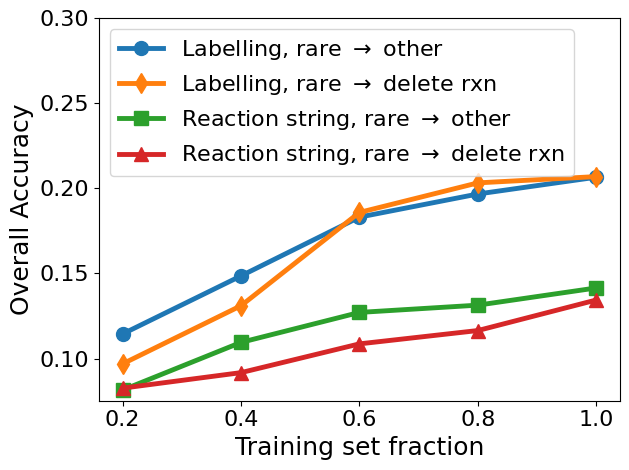

In [97]:
DATASETS = ["with_trust_with_map","with_trust_no_map", "no_trust_no_map", "no_trust_with_map"]
LABELS = {
    "with_trust_with_map": r"Labelling, rare $\rightarrow$ other",
    "with_trust_no_map": r"Labelling, rare $\rightarrow$ delete rxn",
    "no_trust_no_map": r"Reaction string, rare $\rightarrow$ other",
    "no_trust_with_map": r"Reaction string, rare $\rightarrow$ delete rxn",
}
TRAIN_FRACS =  [0.2, 0.4, 0.6, 0.8, 1.0]
fig, ax = plt.subplots(1)
markers = ["o", "d", "s", "^"]
for i, dataset in enumerate(DATASETS):
    overall_accuracies = []
    for train_fraction in TRAIN_FRACS:
        filters = {
            "state": "finished",
            "config.output_folder_path": f"models/{dataset}",
            "config.random_seed": 12345,
            "config.train_fraction": train_fraction,
            "config.train_mode": 0, # Teacher forcing
        }
        runs = api.runs(
            f"{wandb_entity}/{wandb_project}",
            filters=filters
        )
        assert len(runs) == 1
        run = runs[0]

        # Get overall accuracy
        acc = run.summary["test_best"]["overall_accuracy"]
        overall_accuracies.append(acc)
    
    # Add line to plot
    label = LABELS[dataset]
    ax.plot(
        TRAIN_FRACS, 
        overall_accuracies, 
        label=label, 
        linewidth=3.5, 
        marker=markers[i], 
        markersize=10,
    )

# Formatting
axis_fontsize = 16
heading_fontsize = 18
ax.legend(loc="upper left", fontsize=axis_fontsize)
ax.set_xlabel("Training set fraction", fontsize=heading_fontsize)
ax.set_ylabel("Overall Accuracy",  fontsize=heading_fontsize)
ax.set_xticks(TRAIN_FRACS)
ax.set_xticklabels(TRAIN_FRACS, fontsize=axis_fontsize)
ylabels = np.arange(0.1, 0.35, 0.05)
ax.set_yticks(ylabels)
ax.set_yticklabels([f"{ylabel:0.2f}" for ylabel in ylabels], fontsize=axis_fontsize)
fig.tight_layout()
fig.savefig("scaling_behavior.png", dpi=300)